# From Probability to Price  
## A Visual Walk Through Black–Scholes
Developed by: **Sean Sharifi**

This notebook is a **conceptual and visual journey** from probability theory to option pricing.

Rather than starting with formulas, we begin with a simple question:

> *If the future price of an asset is uncertain, how should that uncertainty be priced today?*

The Black–Scholes model answers this question by translating **probability distributions of future prices** into **present option values**.  
My goal here is to make that translation *visible*.

---

## What This Notebook Is About

We will:
- Start with **Brownian motion** and **lognormal price distributions**
- Visualize how uncertainty spreads over time
- Understand what **$d_1$** and **$d_2$** really measure
- See how **$\phi(d_2)$** relates to *where prices are most likely to land*
- Discover why **option Greeks** are not abstract derivatives, but **densities and sensitivities**
- Rebuild the Black–Scholes call price from **expectations**, not memorized formulas

At every step, we will **plot first, explain second, formalize last**.

---

## Philosophy

This notebook follows three principles:

1. **Probability comes before price**  
   Prices are expectations taken under a probability measure.

2. **Geometry beats algebra**  
   If you cannot visualize a quantity, you do not yet understand it.

3. **Every formula must earn its meaning**  
   No symbol is introduced without an interpretation.

---

## Roadmap

1. Probability distributions of returns  
2. From normal returns to lognormal prices  
3. Standardization and the meaning of $d_2$  
4. Change of measure and why pricing is not forecasting  
5. From densities to Greeks  
6. Black–Scholes as a probability identity

---

## Intended Audience

This notebook is written for:
- Aspiring quantitative researchers
- Engineers and scientists transitioning into finance
- Anyone who wants to *understand*, not just apply, Black–Scholes

Some calculus and probability are assumed, but **intuition is always prioritized over rigor**.

---

Let’s begin with uncertainty itself.

## 1. Simulating Uncertainty: Geometric Brownian Motion (GBM)

To understand option pricing, we must first visualize how a stock price evolves over time.  
In the Black–Scholes framework, this evolution is modeled using **Geometric Brownian Motion (GBM)**.

In this model, the infinitesimal change in price $dS_t$ is given by:

$$
dS_t = \mu S_t\,dt + \sigma S_t\,dW_t
$$

where:

- **$\mu$ (Drift):** the expected rate of return  
- **$\sigma$ (Volatility):** the intensity of random fluctuations  
- **$dW_t$ (Wiener process):** a random increment drawn from  
  $$
  \mathcal{N}(0,\,dt)
  $$

This equation combines:
- a **deterministic growth component** ($\mu S_t\,dt$)
- and a **stochastic component** ($\sigma S_t\,dW_t$)

---

## The GBM Solution

Solving this stochastic differential equation yields the closed-form expression used for simulation:

$$
S_t = S_0 \exp\!\left(\left(\mu - \frac{1}{2}\sigma^2\right)t + \sigma W_t\right)
$$

This formula shows that:
- prices evolve **multiplicatively** (The percentage change in price is random — not the absolute change)
- randomness enters through the Brownian motion term $W_t$
- volatility controls the *spread* of future outcomes, not their direction

---

## Interpretation

The plot below shows multiple simulated price paths for the same asset.

Each path represents a different possible **future realization** under the same model assumptions.  
As time increases, the paths fan out, visually demonstrating how **uncertainty grows with horizon**.

This expanding cloud of possible prices is the raw material from which option prices are constructed.



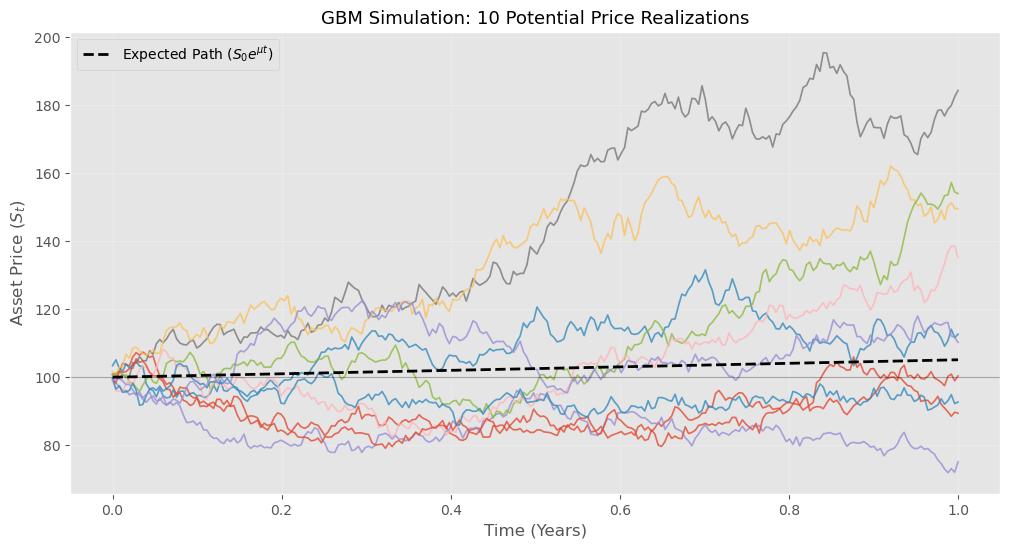

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Model Parameters
config = {
    'S0': 100,          
    'mu': 0.05,         # Annual drift
    'sigma': 0.25,      # Annual volatility
    'T': 1.0,           
    'dt': 1/252,        # Daily time steps
    'n_paths': 10,      
    'seed': 42          
}

# Time grid setup
np.random.seed(config['seed'])
n_steps = int(config['T'] / config['dt'])
t = np.linspace(0, config['T'], n_steps)

# Generate Brownian increments and paths
# dW ~ N(0, dt)
dW = np.random.standard_normal(size=(config['n_paths'], n_steps))
W = np.cumsum(dW, axis=1) * np.sqrt(config['dt']) 

# Solve for S_t using the SDE closed-form solution:
# S_t = S0 * exp((mu - 0.5*sigma^2)t + sigma*W_t)
convexity_adj = (config['mu'] - 0.5 * config['sigma']**2) * t
diffusion = config['sigma'] * W
paths = config['S0'] * np.exp(convexity_adj + diffusion)

# Plotting simulation results
plt.figure(figsize=(12, 6))
plt.plot(t, paths.T, lw=1.2, alpha=0.8)

# Overlay the expected growth path: S0 * exp(mu * t)
plt.plot(t, config['S0'] * np.exp(config['mu'] * t), 
         color='black', ls='--', lw=2, label=r'Expected Path ($S_0 e^{\mu t}$)')

plt.title(f"GBM Simulation: {config['n_paths']} Potential Price Realizations", fontsize=13)
plt.xlabel("Time (Years)")
plt.ylabel(r"Asset Price ($S_t$)")
plt.axhline(config['S0'], color='black', lw=0.8, alpha=0.3)
plt.legend(frameon=True)
plt.grid(True, alpha=0.2)
plt.show()

## 2. From Normal Returns to Lognormal Prices

While individual price paths look random, their collective end-state is highly structured. In the Black–Scholes world, we assume log-returns are normally distributed. Because of the exponential nature of price growth.

$$
S_t = S_0 e^{r t}
$$

As a result, even if returns are normal, **prices are not**.  
They follow a **lognormal distribution**.

This transformation—from normal returns to lognormal prices—is purely mathematical.  
No new randomness is introduced; only the *scale* changes.

---

## Key Implications

This shift has two critical implications for understanding risk and reward.

### Prices Cannot Be Negative

The lognormal distribution is bounded below by zero:

$$
S_t > 0
$$

This reflects the limited liability of a stock:  
the maximum loss is 100%, but not more.

---

### Positive Skewness

Unlike the symmetric bell curve of returns, the price distribution is **right-skewed**.

- Losses are capped
- Gains are unbounded

This produces a long right tail, meaning:
> extreme positive outcomes are rare, but possible

This asymmetry is fundamental to option pricing.

---

## What We Will Compare Next

In the next code cell, we will:

- Take the terminal values from the GBM simulation
- Plot the distribution of **log-returns**
- Plot the distribution of **prices**
- See directly how symmetry in return space becomes skewness in price space

This visual contrast is the clearest way to understand why options derive value from volatility.


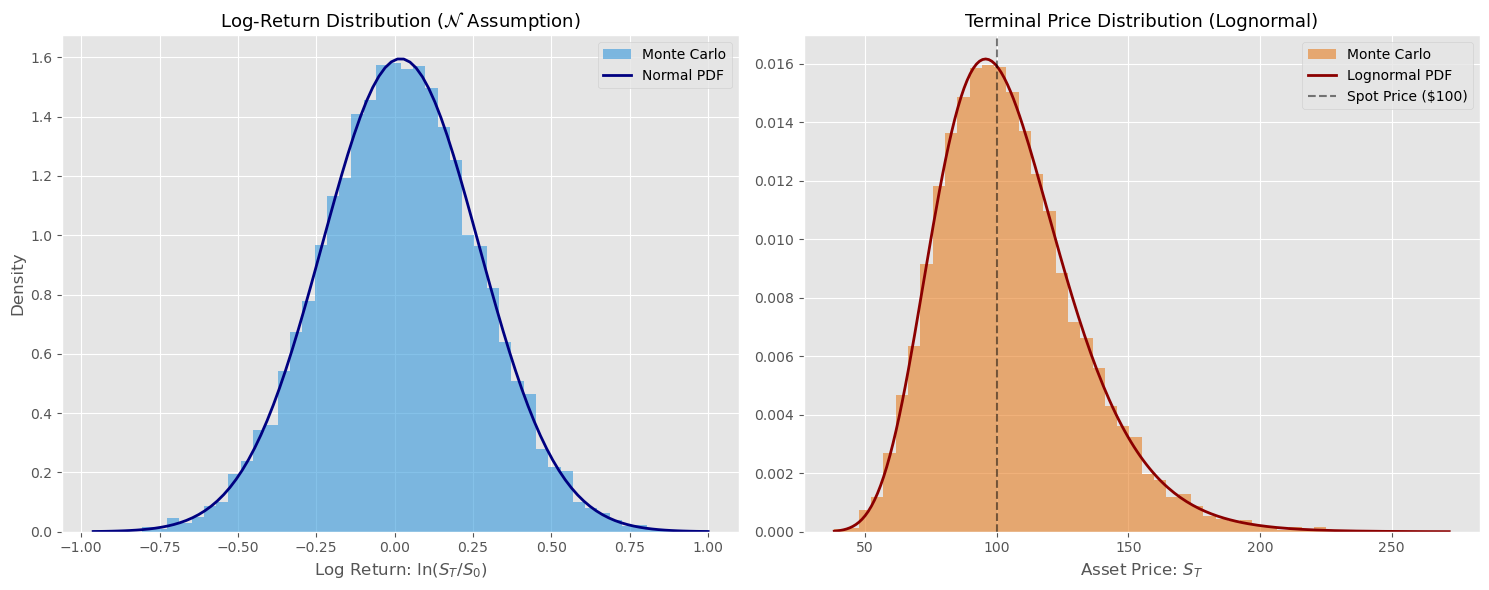

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm

# Terminal distribution parameters
n_sims = 10000 
np.random.seed(config['seed'])

# Calculate the mean and std for the log-return space
mu_log = (config['mu'] - 0.5 * config['sigma']**2) * config['T']
sigma_log = config['sigma'] * np.sqrt(config['T'])

# Generate returns and terminal prices directly via closed-form solution
z_scores = np.random.standard_normal(n_sims)
log_returns = mu_log + sigma_log * z_scores
final_prices = config['S0'] * np.exp(log_returns)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Left: Log-Return Space (Normal Distribution)
ax1.hist(log_returns, bins=50, density=True, alpha=0.6, color='#3498db', label='Monte Carlo')
x_ret = np.linspace(log_returns.min(), log_returns.max(), 100)
ax1.plot(x_ret, norm.pdf(x_ret, mu_log, sigma_log), color='navy', lw=2, label='Normal PDF')
ax1.set_title(r'Log-Return Distribution ($\mathcal{N}$ Assumption)', fontsize=13)
ax1.set_xlabel(r'Log Return: $\ln(S_T/S_0)$')
ax1.set_ylabel('Density')
ax1.legend()

# Right: Price Space (Lognormal Distribution)
ax2.hist(final_prices, bins=50, density=True, alpha=0.6, color='#e67e22', label='Monte Carlo')
x_price = np.linspace(final_prices.min(), final_prices.max(), 200)

# Scipy lognorm uses 's' as the shape (sigma_log) and 'scale' as exp(mu_log)
# Since ST = S0 * exp(r), the scale parameter is S0 * exp(mu_log)
ax2.plot(x_price, lognorm.pdf(x_price, s=sigma_log, scale=config['S0'] * np.exp(mu_log)), 
         color='darkred', lw=2, label='Lognormal PDF')
ax2.axvline(config['S0'], color='black', ls='--', alpha=0.5, label=f'Spot Price (${config["S0"]})')

ax2.set_title(r'Terminal Price Distribution (Lognormal)', fontsize=13)
ax2.set_xlabel(r'Asset Price: $S_T$')
ax2.legend()

plt.tight_layout()
plt.show()

## 3. The “Bet”: Probability of Finishing In-The-Money ($d_2$)

An option can be thought of as a **bet on an outcome**.

For a **call option**, the question is simple:

> *Will the terminal price $S_T$ end up above the strike price $K$?*

If the answer is yes, the option pays off.  
If not, it expires worthless.

---

## $d_2$ as a Z-Score

To quantify this probability, Black–Scholes introduces the quantity $d_2$.

In the world of **log-returns**, $d_2$ is simply a **standardized distance**, or **Z-score**.

It measures how many standard deviations the *strike hurdle* is away from the expected log-return:

$$
d_2
=
\frac{\ln\!\left(\frac{S_0}{K}\right)
+ \left(r - \tfrac{1}{2}\sigma^2\right)T}
{\sigma\sqrt{T}}
$$

Interpreted probabilistically:
- The numerator shifts and centers the strike in log-space
- The denominator rescales uncertainty into standard deviations

---

## Probability of Finishing ITM

Because $d_2$ is a Z-score, applying the standard normal CDF gives a probability:

$$
N(d_2) = \mathbb{Q}(S_T > K)
$$

That is,

> **$N(d_2)$ is the risk-neutral probability that the call option finishes In-The-Money(i.e. the price will end up above the strike price**

This probability will form the backbone of the Black–Scholes pricing formula — and it emerges naturally from the geometry of the price distribution.


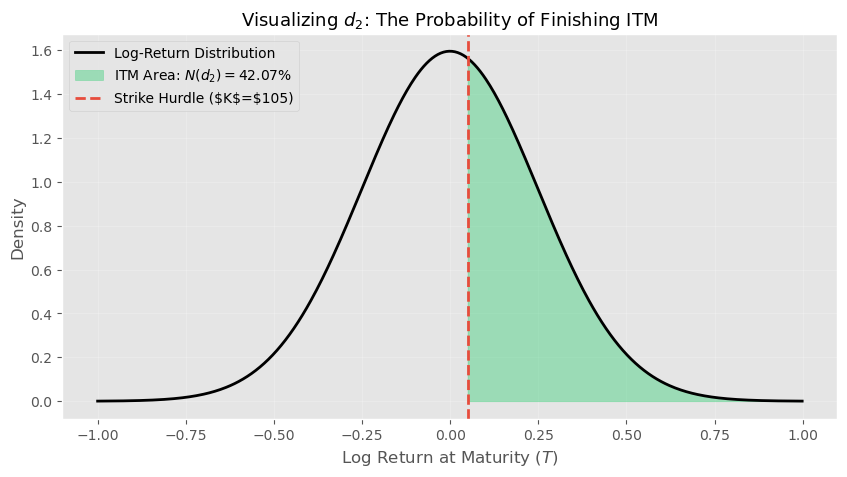

Calculated d2: -0.2002
Risk-Neutral Probability of Exercise: 0.4207


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Pricing Parameters
K = 105           # Strike Price
r = 0.03          # Risk-free rate 

# Distribution parameters in log-space
mu_log = (r - 0.5 * config['sigma']**2) * config['T']
sigma_log = config['sigma'] * np.sqrt(config['T'])
log_hurdle = np.log(K / config['S0'])

# Calculate d2: The standardized distance to the strike hurdle
d2 = (np.log(config['S0'] / K) + (r - 0.5 * config['sigma']**2) * config['T']) / (config['sigma'] * np.sqrt(config['T']))
prob_itm = norm.cdf(d2)

# Visualization of the ITM "Bet"
plt.figure(figsize=(10, 5))
x = np.linspace(mu_log - 4 * sigma_log, mu_log + 4 * sigma_log, 500)
pdf = norm.pdf(x, mu_log, sigma_log)

plt.plot(x, pdf, color='black', lw=2, label='Log-Return Distribution')

# Highlight area where ST > K
# Note: We escape the % sign with \% for Matplotlib LaTeX compatibility
plt.fill_between(x, pdf, where=(x > log_hurdle), color='#2ecc71', alpha=0.4, 
                 label=r'ITM Area: $N(d_2) = ' + f'{prob_itm:.2%}'.replace('%', r'\%') + r'$')

plt.axvline(log_hurdle, color='#e74c3c', ls='--', lw=2, label=f'Strike Hurdle ($K$=${K})')

plt.title(r"Visualizing $d_2$: The Probability of Finishing ITM", fontsize=13)
plt.xlabel(r"Log Return at Maturity ($T$)")
plt.ylabel("Density")
plt.legend(loc='upper left')
plt.grid(alpha=0.2)
plt.show()

print(f"Calculated d2: {d2:.4f}")
print(f"Risk-Neutral Probability of Exercise: {prob_itm:.4f}")

## 4. The “Price”: Risk-Neutrality and Change of Measure

We now reach the most famous conceptual leap in modern finance.

> **Why do we price options using the risk-free rate $r$ instead of the real-world expected return $\mu$?**

At first glance, this seems unnatural.  
Stocks earn a risk premium in the real world — why should option pricing ignore it?

---

## Risk Premium in the Real World

In reality:
- Investors dislike risk
- Risky assets must offer higher expected returns
- This extra return is the **risk premium**

That premium is embedded in the real-world drift $\mu$.

---

## The Hedging Insight

Black and Scholes made a crucial observation:

> An option can be dynamically hedged using the underlying stock.

By continuously adjusting a hedge position, the combined portfolio:
- Eliminates randomness
- Becomes locally riskless
- Must therefore earn the **risk-free rate**

In this hedged portfolio, the stock’s risk premium **cancels out**.

Dynamic hedging allows an option seller to quote and sell options without taking a directional bet, which is why option pricing is driven by replication rather than prediction.

---

## Risk-Neutral Pricing

As a result, option pricing does **not** depend on what investors *expect* the stock to do.

Instead, pricing is performed under a fictitious—but mathematically consistent—world where:

- All assets grow at the risk-free rate $r$
- Investors are **risk-neutral**
- Only arbitrage matters

This is called **risk-neutral valuation**.

---

## Change of Measure

Mathematically, this idea is expressed as a **change of probability measure**.

- We move from the real-world measure (with drift $\mu$)
- To the risk-neutral measure (with drift $r$)

This change effectively shifts the center of the return distribution  
(to the left when $r < \mu$).

Crucially:

> We are **not forecasting** what the stock will do.  
> We are computing what the option **must** be worth today to prevent arbitrage.

---

## The Pricing Principle

Under the risk-neutral measure, the option price is:

$$
\text{Option Price}
=
e^{-rT}\,
\mathbb{E}^{\mathbb{Q}}\!\left[\text{Payoff at } T\right]
$$

Probability has now become **price**.

---

## Takeaway

> **Risk-neutral pricing is not an assumption about human behavior — it is a consequence of arbitrage and hedging.**

This shift from $\mu$ to $r$ is the final conceptual bridge between uncertainty and value.


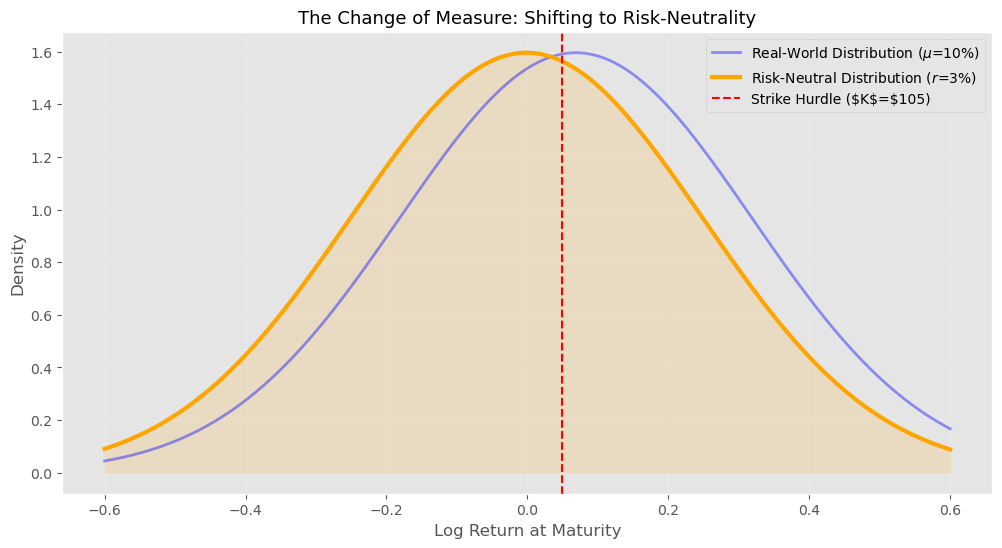

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Real-world vs Risk-neutral drift parameters
mu_real = 0.10    
r_free = 0.03     
log_hurdle = np.log(105 / config['S0'])

# Distribution parameters (shifted by risk premium)
x = np.linspace(-0.6, 0.6, 500)
pdf_real = norm.pdf(x, (mu_real - 0.5 * config['sigma']**2) * config['T'], 
                    config['sigma'] * np.sqrt(config['T']))
pdf_risk_neutral = norm.pdf(x, (r_free - 0.5 * config['sigma']**2) * config['T'], 
                            config['sigma'] * np.sqrt(config['T']))

# Visualization
plt.figure(figsize=(12, 6))

plt.plot(x, pdf_real, color='blue', lw=2, alpha=0.4, 
         label=r'Real-World Distribution ($\mu$=' + f'{mu_real:.0%})')
plt.plot(x, pdf_risk_neutral, color='orange', lw=3, 
         label=r'Risk-Neutral Distribution ($r$=' + f'{r_free:.0%})')

plt.fill_between(x, pdf_risk_neutral, color='orange', alpha=0.15)
plt.axvline(log_hurdle, color='red', ls='--', label=f'Strike Hurdle ($K$=${105})')

plt.title("The Change of Measure: Shifting to Risk-Neutrality", fontsize=13)
plt.xlabel("Log Return at Maturity")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

## 5. The “Expectation”: Rebuilding the Black–Scholes Call Formula

Under the risk-neutral measure, the price of an option is simply the **discounted expected payoff**.

For a European call option, this expectation can be evaluated in closed form, yielding the familiar Black–Scholes formula:

$$
C
=
S_0\,N(d_1)
-
K e^{-rT}\,N(d_2)
$$

Rather than treating this as a formula to memorize, we can interpret it as the sum of **two distinct probabilistic components**.

---

## The Two Components of the Call Price

### The Strike Component

$$
K e^{-rT}\,N(d_2)
$$

This term represents:
- The **present value of the strike price** paid at maturity
- Weighted by the **risk-neutral probability of exercise**, $N(d_2)$

In other words, it is the expected discounted cost of exercising the option, accounting for the fact that exercise occurs only when $S_T > K$.

---

### The Stock Component

$$
S_0\,N(d_1)
$$

This term represents:
- The value of the **stock received at maturity**
- probability of finishing ITM under the **stock measure** (or the "numeraire" measure where the stock itself is the unit of account)., $N(d_1)$

The quantity $N(d_1)$ is also the **delta** of the call option.  
It tells us how much of the underlying stock a market maker must hold in order to dynamically hedge the option’s risk.

Unlike $N(d_2)$, this probability weights outcomes by **how large the stock price is**, not merely by whether the option finishes In-The-Money.

---

## Interpretation

Together, these two terms express a simple idea:

> **Option value is the difference between what you expect to receive and what you expect to pay, under risk-neutral probabilities.**

The appearance of both $d_1$ and $d_2$ is not redundant — it reflects two different ways of averaging over future uncertainty.

---

## What We Will Do Next

In the next cell, we will compute the call price directly by:
- Simulating terminal stock prices
- Applying the payoff $(S_T - K)^+$
- Taking the empirical expectation
- Discounting back to today

This will reconstruct the Black–Scholes price **from the expectation itself**, rather than from the closed-form formula.


In [21]:
import numpy as np
from scipy.stats import norm

# Using a high number of simulations for a precise empirical average
n_sims = 100000
np.random.seed(config['seed'])

# --- 1. Risk-Neutral Simulation ---
# We use 'r' (risk-free rate) from config instead of 'mu' (real-world drift)
Z = np.random.standard_normal(n_sims)
ST = config['S0'] * np.exp((r_free - 0.5 * config['sigma']**2) * config['T'] + 
                             config['sigma'] * np.sqrt(config['T']) * Z)

# --- 2. Empirical Expectation ---
# Payoff = Max(S_T - K, 0)
payoffs = np.maximum(ST - K, 0)
simulated_price = np.exp(-r_free * config['T']) * np.mean(payoffs)

# --- 3. Black-Scholes Closed-Form Solution ---
d1 = (np.log(config['S0'] / K) + (r_free + 0.5 * config['sigma']**2) * config['T']) / (config['sigma'] * np.sqrt(config['T']))
d2 = d1 - config['sigma'] * np.sqrt(config['T'])
bs_price = config['S0'] * norm.cdf(d1) - K * np.exp(-r_free * config['T']) * norm.cdf(d2)

print(f"Risk-Neutral Expected Price (Simulation): ${simulated_price:.4f}")
print(f"Black-Scholes Theoretical Price:         ${bs_price:.4f}")
print(f"Difference:                              ${abs(simulated_price - bs_price):.6f}")

Risk-Neutral Expected Price (Simulation): $9.1474
Black-Scholes Theoretical Price:         $9.1218
Difference:                              $0.025616


## 6. The “Sensitivity”: Option Greeks as Geometry

In finance, option **Greeks** are often introduced as abstract partial derivatives.

However, following our guiding principle that **geometry beats algebra**, we can interpret Greeks as **physical sensitivities of the probability distribution** rather than purely symbolic calculations.

They describe how the option price responds when the underlying uncertainty is shifted, stretched, or reshaped.

---

## Delta — Directional Sensitivity

**Delta**, given by $N(d_1)$, is the **slope of the option price curve** with respect to the stock price.

Geometrically, it represents:
- The **probability-weighted exposure** to the stock
- How much the option behaves like the underlying asset

From a hedging perspective:
- Delta tells us how many shares of stock are required to hedge one option
- It is the amount of stock a market maker must hold to remain locally risk-neutral

---



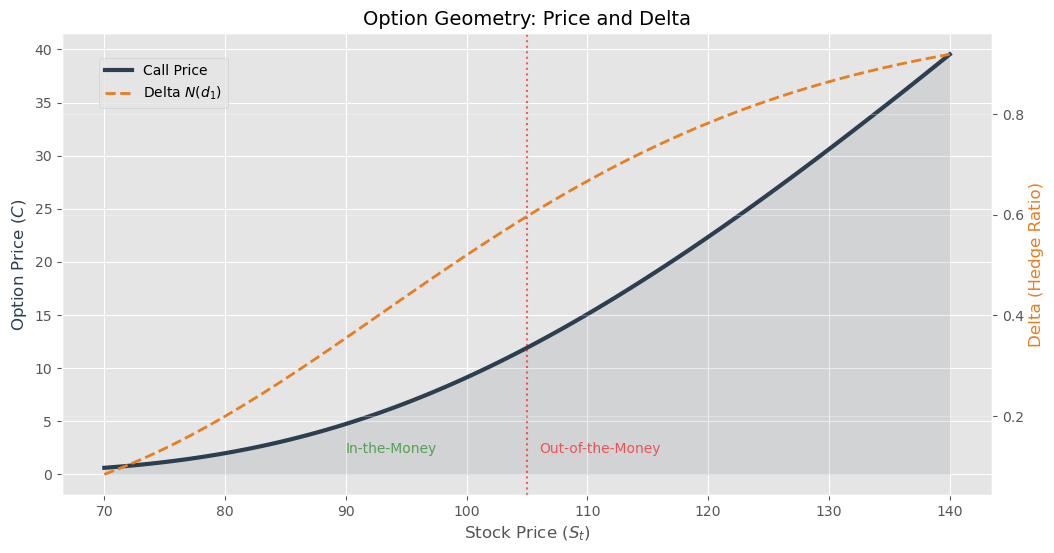

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# --- 1. Functions ---
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2), norm.cdf(d1)

# --- 2. Parameters ---
# Using shared config for consistency and defining local strike/rate
K = 105
r = 0.03
S_range = np.linspace(config['S0']*0.7, config['S0']*1.4, 100)

# --- 3. Calculate Price and Delta ---
prices, deltas = black_scholes_call(S_range, K, config['T'], r, config['sigma'])

# --- 4. Visualization ---
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Call Price
ax1.plot(S_range, prices, color='#2c3e50', lw=3, label='Call Price')
ax1.fill_between(S_range, prices, alpha=0.1, color='#2c3e50')
ax1.set_xlabel(r'Stock Price ($S_t$)', fontsize=12)
ax1.set_ylabel(r'Option Price ($C$)', fontsize=12, color='#2c3e50')

# Plot Delta on a secondary axis
ax2 = ax1.twinx()
ax2.plot(S_range, deltas, color='#e67e22', lw=2, ls='--', label=r'Delta $N(d_1)$')
ax2.set_ylabel('Delta (Hedge Ratio)', fontsize=12, color='#e67e22')

# Annotations
ax1.axvline(K, color='red', ls=':', alpha=0.6)
ax1.text(K+1, 2, 'Out-of-the-Money', color='red', alpha=0.6)
ax1.text(K-15, 2, 'In-the-Money', color='green', alpha=0.6)

plt.title("Option Geometry: Price and Delta", fontsize=14)
fig.legend(loc="upper left", bbox_to_anchor=(0.15, 0.85))
plt.grid(alpha=0.3)
plt.show()

While **Delta** tells us our *directional exposure*, **Gamma** and **Vega** tell us about our **stability**.

They describe how fragile or robust a hedge is when conditions change.

---

## Gamma — Curvature and Hedge Stability

**Gamma** measures the **rate of change of Delta** with respect to the stock price.

Geometrically:
- Gamma is the **curvature** of the option price curve
- It tells us how quickly the slope (Delta) changes as the stock moves

Interpretation:
- **High Gamma** means Delta changes rapidly
- Hedging must be adjusted **frequently and aggressively**
- Small price moves can significantly alter exposure

Gamma is largest near the strike region, but its maximum typically occurs slightly below the strike (spot), where the outcome of the option is most uncertain and the payoff boundary is closest.

---

## Vega — Expansion of Uncertainty

**Vega** measures sensitivity to **volatility**, not price.

Geometrically:
- Vega captures how the option price responds when the **distribution of future prices expands or contracts**
- Higher volatility spreads probability mass outward
- Lower volatility concentrates outcomes near the center

Interpretation:
- Increasing volatility increases the value of convex payoffs
- Vega quantifies how valuable that additional uncertainty is to the option holder

---

## Takeaway

> **Delta describes exposure, Gamma describes stability, and Vega describes sensitivity to the width of uncertainty itself.**

Together, they complete the geometric picture of option risk.


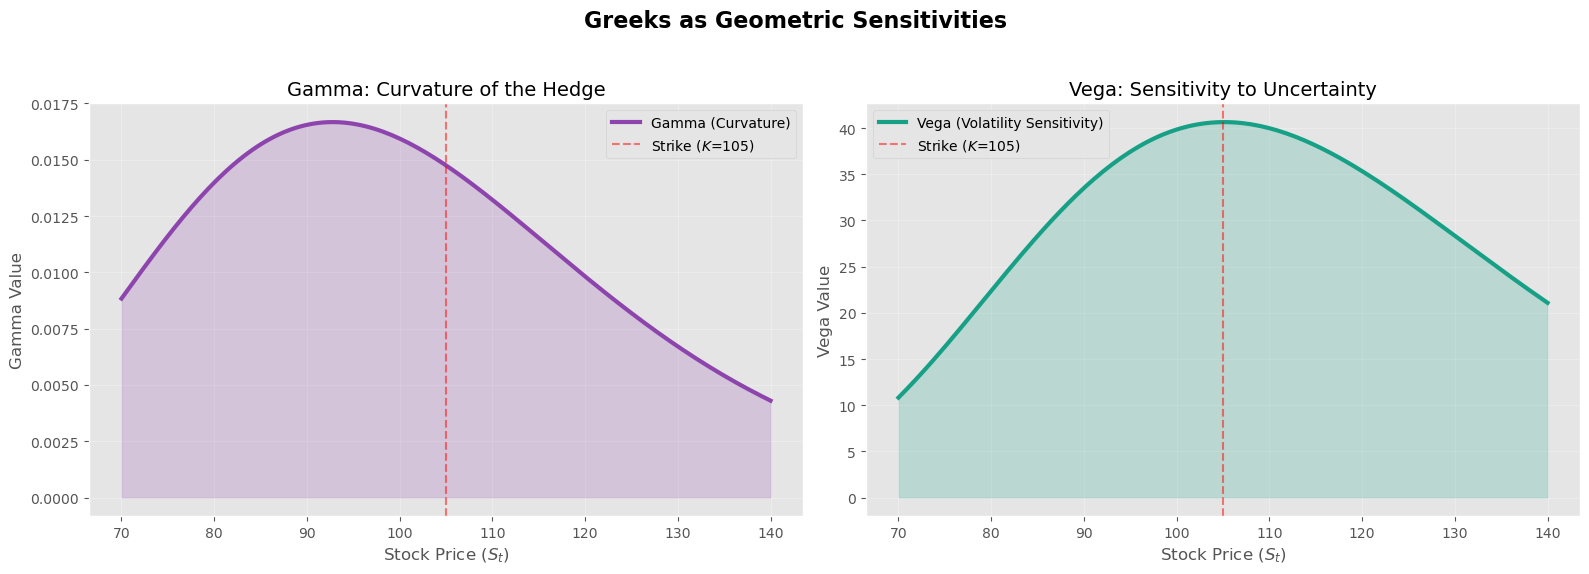

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# --- 1. Black-Scholes Greek Functions ---
def calculate_greeks(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    
    # Gamma: Change in Delta / Change in Price
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    
    # Vega: Change in Price / Change in Volatility
    vega = S * norm.pdf(d1) * np.sqrt(T)
    
    return gamma, vega

# --- 2. Parameters ---
# Pulling from global config for consistency
S0 = config['S0']
K = 105
r = 0.03
T = config['T']
sigma = config['sigma']
S_range = np.linspace(70, 140, 150)

# --- 3. Compute Greeks ---
gammas, vegas = calculate_greeks(S_range, K, T, r, sigma)

# --- 4. Visualization ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: Gamma (The Danger Zone)
ax1.plot(S_range, gammas, color='#8e44ad', lw=3, label='Gamma (Curvature)')
ax1.fill_between(S_range, gammas, alpha=0.2, color='#8e44ad')
ax1.axvline(K, color='red', ls='--', alpha=0.5, label=f'Strike ($K$={K})')
ax1.set_title('Gamma: Curvature of the Hedge', fontsize=14)
ax1.set_xlabel(r'Stock Price ($S_t$)')
ax1.set_ylabel('Gamma Value')
ax1.legend()
ax1.grid(alpha=0.3)

# Right: Vega (Volatility Sensitivity)
ax2.plot(S_range, vegas, color='#16a085', lw=3, label='Vega (Volatility Sensitivity)')
ax2.fill_between(S_range, vegas, alpha=0.2, color='#16a085')
ax2.axvline(K, color='red', ls='--', alpha=0.5, label=f'Strike ($K$={K})')
ax2.set_title('Vega: Sensitivity to Uncertainty', fontsize=14)
ax2.set_xlabel(r'Stock Price ($S_t$)')
ax2.set_ylabel('Vega Value')
ax2.legend()
ax2.grid(alpha=0.3)

plt.suptitle("Greeks as Geometric Sensitivities", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Conclusion: From Uncertainty to Value

This notebook began with a simple question:

> *If the future price of an asset is uncertain, how should that uncertainty be priced today?*

By answering it step by step, we have rebuilt the Black–Scholes model from first principles.

---

## What We Have Shown

We did **not** start with formulas.  
We started with **uncertainty**.

Along the way, we showed that:

- Price uncertainty can be modeled as a **probability distribution**
- Log-returns are normal, which makes prices **lognormal**
- Options extract value by **filtering and weighting** that distribution
- Pricing is not forecasting, but **arbitrage-free valuation**
- Risk-neutral probabilities arise from **hedging**, not beliefs
- The Black–Scholes formula is simply the **discounted expectation of a payoff**
- Greeks are not abstract derivatives, but **geometric sensitivities**
  - Delta is slope
  - Gamma is curvature
  - Vega is expansion of uncertainty

At every step, probability was transformed into expectation, and expectation into price.

---

## The Central Insight

The Black–Scholes model is often taught as a collection of formulas.

In reality, it is a single idea expressed in different languages:

> **Price is the value required today to replicate a future payoff under uncertainty.**

Everything else — \(d_1\), \(d_2\), Greeks, risk-neutral measures — follows inevitably from that principle.

---

## Why This Matters

Understanding Black–Scholes this way changes how you think about markets:

- Options are not bets on direction, but **contracts on distributions**
- Volatility is not noise, but **the raw material of value**
- Hedging is geometry, not guesswork
- Pricing is constrained by replication, not opinion

This perspective extends far beyond Black–Scholes — to interest-rate models, credit risk, and modern derivatives pricing.

---

## Final Thought

If there is one takeaway from this notebook, it is this:

> **Finance is not about predicting the future — it is about assigning value to uncertainty in a way that leaves no free lunch.**

That is the quiet power of Black–Scholes.

---

*End of notebook.*
